# Modeling seizure freedom (binary) using clinical data

## Import data

In [45]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\Amaury\AppData\Local\Temp\ipykernel_14884\4254179035.py:4: DtypeWarning: Columns (859,862) have mixed types. Specify dtype option on import or set low_memory=False.
  wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")


## Select features

In [46]:
# Selecting patients who only went through 1 surgery
wide_df = wide_df[wide_df["surgical_information"]==1]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset_hw", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "freq_per_month_hw", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15", "seizure_notes_word_cnt"]]

# Select the handwritten columns as final columns (manually checked and annotated)
X = X.rename(columns={"age_of_onset_hw": "age_of_onset",
                      "freq_per_month_hw": "freq_per_month"})

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## Correlation matrix

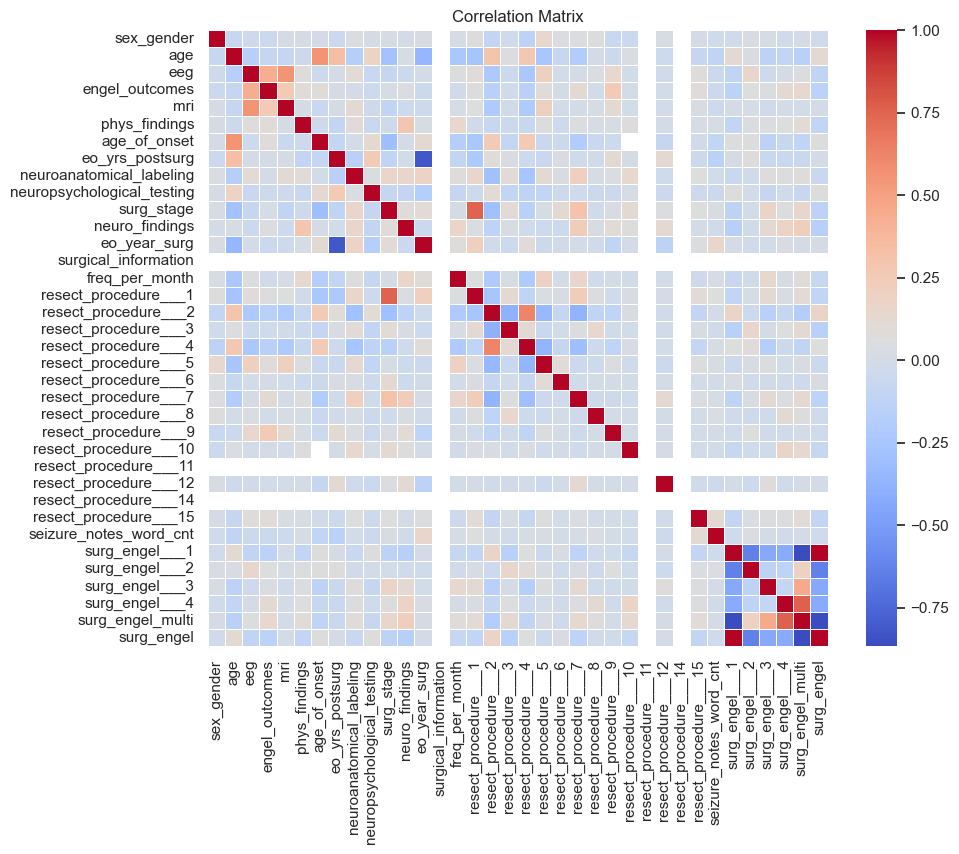

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X, engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [48]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## To transform from a multiclass prediction to a single class prediction

In [49]:
# Trying to predict Engel class I
y = y==0

## Split data into train/test

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 10-fold cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

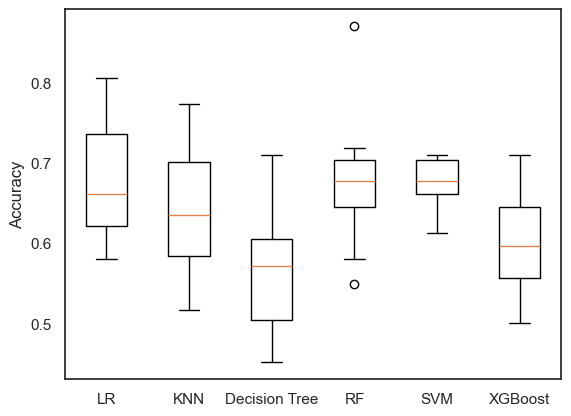

In [51]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]
column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf)

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.ylabel('Accuracy')
plt.show()

### Nested CV with hyperparameter tuning

In the following, I plotted the AUC score for a few models after preprocessing, feature selection and hyperparameter tuning.

The inner CV is for hyperparameter tuning while the outer CV is for scoring.

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1250 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ama

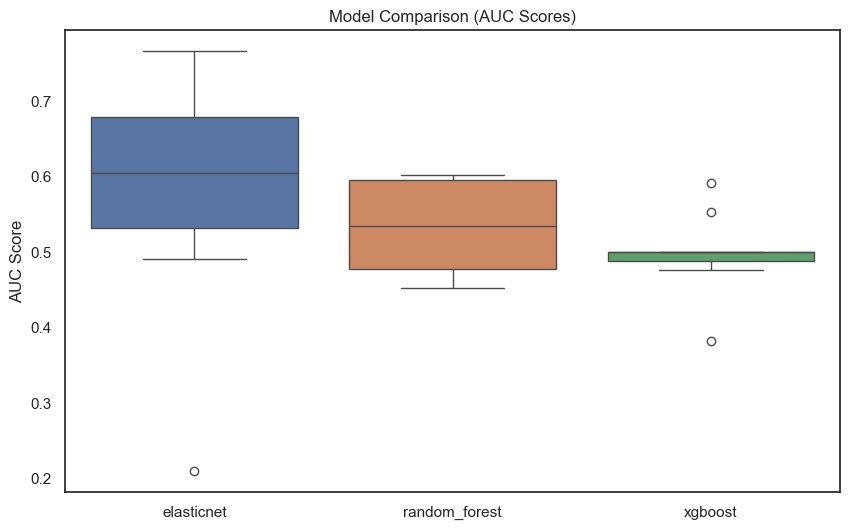

Selected Features for elasticnet: [['sex_gender', 'age', 'phys_findings', 'age_of_onset', 'freq_per_month', 'resect_procedure___1'], ['sex_gender', 'age', 'eeg', 'engel_outcomes', 'mri', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'neuroanatomical_labeling', 'neuropsychological_testing', 'surg_stage', 'neuro_findings', 'eo_year_surg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___2', 'resect_procedure___3', 'resect_procedure___4', 'resect_procedure___5', 'resect_procedure___6', 'resect_procedure___7', 'resect_procedure___8', 'resect_procedure___9', 'resect_procedure___10', 'resect_procedure___11', 'resect_procedure___12', 'resect_procedure___14', 'resect_procedure___15', 'seizure_notes_word_cnt'], ['sex_gender', 'age', 'age_of_onset', 'resect_procedure___1'], ['sex_gender', 'age', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___3'], ['sex_gender', 'a

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

X_CV = X_train
y_CV = y_train

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipelines with named steps and feature selection
model_pipelines = {
    'elasticnet': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(ElasticNet())),
        ('model', ElasticNet())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier())
    ]),
    'xgboost': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))),
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}

# Define hyperparameter grids for each model
models_and_parameters = {
    'elasticnet': {'feature_selection__estimator__alpha': np.linspace(0.1, 10, 5), 
                   'feature_selection__estimator__l1_ratio': np.linspace(0.1, 1, 5),
                   'model__alpha': np.linspace(0.1, 1, 5), 
                   'model__l1_ratio': np.linspace(0.1, 1, 5)},
    'random_forest': {'feature_selection__estimator__n_estimators': [20, 50], 
                      'model__n_estimators': [20, 50], 
                      'model__max_depth': [5, 10]},
    'xgboost': {'feature_selection__estimator__n_estimators': [20, 50], 
                'model__n_estimators': [20, 50], 
                'model__learning_rate': np.logspace(-3, -1, 3)}
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10)
inner_cv = StratifiedKFold(n_splits=10)
results = {}
selected_features = {}
best_params = {}

for model_name, pipeline in model_pipelines.items():
    param_grid = models_and_parameters[model_name]
    auc_scores = []
    features_selected = []
    params = []

    for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
        X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model and parameters
        best_model = grid_search.best_estimator_
        params.append(grid_search.best_params_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test_fold)
        auc_score = roc_auc_score(y_test_fold, y_pred)
        auc_scores.append(auc_score)

        # Store selected features
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        features = list(X_CV.columns[selected_mask])
        features_selected.append(features)

    results[model_name] = auc_scores
    selected_features[model_name] = features_selected
    best_params[model_name] = params

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame(results)

# Plot AUC scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_scores)
plt.title('Model Comparison (AUC Scores)')
plt.ylabel('AUC Score')
plt.show()

# Print selected features and best parameters
for model in selected_features:
    print(f"Selected Features for {model}: {selected_features[model]}")
    print(f"Best Parameters for {model}: {best_params[model]}")

Now let's focus on the elasticnet

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1250 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ama

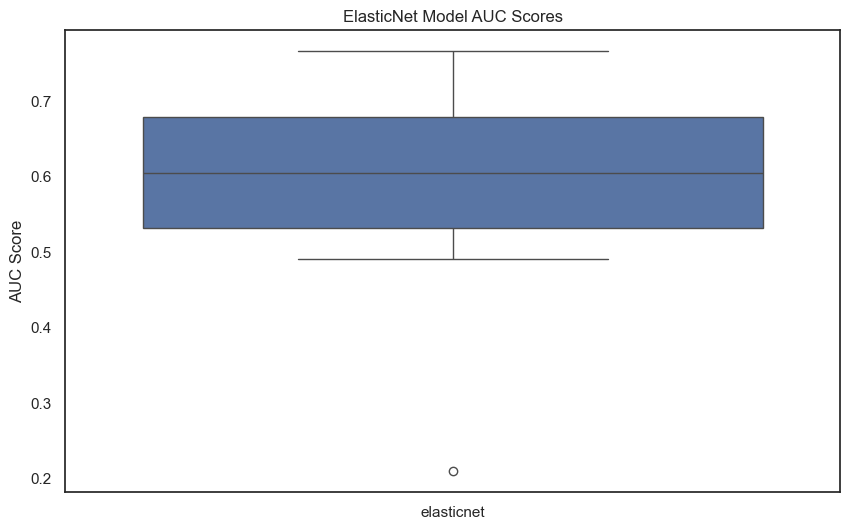

Selected Features for ElasticNet: [['sex_gender', 'age', 'phys_findings', 'age_of_onset', 'freq_per_month', 'resect_procedure___1'], ['sex_gender', 'age', 'eeg', 'engel_outcomes', 'mri', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'neuroanatomical_labeling', 'neuropsychological_testing', 'surg_stage', 'neuro_findings', 'eo_year_surg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___2', 'resect_procedure___3', 'resect_procedure___4', 'resect_procedure___5', 'resect_procedure___6', 'resect_procedure___7', 'resect_procedure___8', 'resect_procedure___9', 'resect_procedure___10', 'resect_procedure___11', 'resect_procedure___12', 'resect_procedure___14', 'resect_procedure___15', 'seizure_notes_word_cnt'], ['sex_gender', 'age', 'age_of_onset', 'resect_procedure___1'], ['sex_gender', 'age', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___3'], ['sex_gender', 'a

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

X_CV = X_train
y_CV = y_train

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipeline with named steps and feature selection for ElasticNet
elasticnet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(ElasticNet())),
    ('model', ElasticNet())
])

# Define hyperparameter grid for ElasticNet
elasticnet_parameters = {
    'feature_selection__estimator__alpha': np.linspace(0.1, 10, 5), 
    'feature_selection__estimator__l1_ratio': np.linspace(0.1, 1, 5),
    'model__alpha': np.linspace(0.1, 1, 5), 
    'model__l1_ratio': np.linspace(0.1, 1, 5)
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10)
inner_cv = StratifiedKFold(n_splits=10)

auc_scores = []
features_selected = []
best_params = []

for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
    X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
    y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

    # Inner CV for hyperparameter tuning
    grid_search = GridSearchCV(elasticnet_pipeline, elasticnet_parameters, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)

    # Evaluate on test set
    y_pred = best_model.predict(X_test_fold)
    auc_score = roc_auc_score(y_test_fold, y_pred)
    auc_scores.append(auc_score)

    # Store selected features
    selected_mask = best_model.named_steps['feature_selection'].get_support()
    features = list(X_CV.columns[selected_mask])
    features_selected.append(features)

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame({'elasticnet': auc_scores})

# Plot AUC scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=all_scores)
plt.title('ElasticNet Model AUC Scores')
plt.ylabel('AUC Score')
plt.show()

# Print selected features and best parameters for ElasticNet
print(f"Selected Features for ElasticNet: {features_selected}")
print(f"Best Parameters for ElasticNet: {best_params}")


## Scale continuous variables

In [24]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")

Null Accuracy: 0.68


## ROC AND AUC

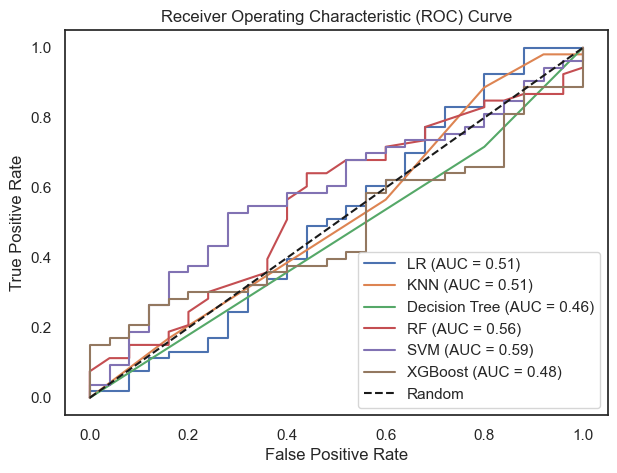

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision function
        y_pred_prob = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier
lr = LogisticRegression(max_iter=2000, random_state=42)

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

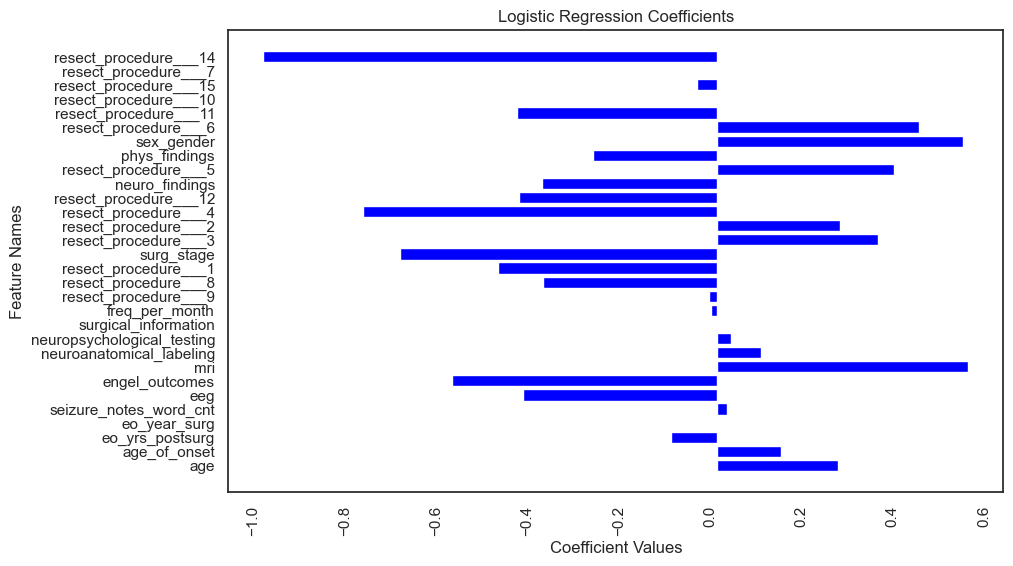

In [28]:
import numpy as np

# Get the coefficients and feature names
coefficients = lr.coef_.flatten()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(column_names, coefficients, color='blue')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha="right")
plt.show()

In [29]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)


Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(3.1442 + 0.2649 * age + 0.1403 * age_of_onset + -0.1012 * eo_yrs_postsurg + -0.0005 * eo_year_surg + 0.0218 * seizure_notes_word_cnt + -0.4262 * eeg + -0.5798 * engel_outcomes + 0.5494 * mri + 0.0966 * neuroanatomical_labeling + 0.0314 * neuropsychological_testing + 0.0000 * surgical_information + -0.0139 * freq_per_month )))


### Feature selection

Shows important features by applying LASSO regression (L1 regularization) to penalize the absolute size of coefficients. This tends to shrink some coefficients to zero, effectively selecting a subset of features.

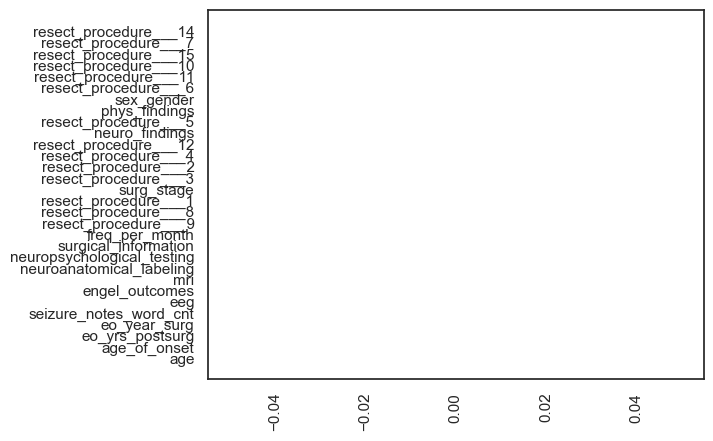

In [30]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

# Filter out columns with coefficient equal to 0
nonzero_coef_indices = np.where(lasso_coef != 0)[0]
nonzero_names = [column_names[i] for i in nonzero_coef_indices]  # Use a list comprehension to get the names
nonzero_coef = lasso_coef[nonzero_coef_indices]

plt.barh(column_names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Decision Tree classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth = 3, random_state=42)

# Turn outcome variable into dummy variables
y_train_encoded = pd.get_dummies(y_train, columns=["surg_engel"], drop_first=True)
y_test_encoded = pd.get_dummies(y_test, columns=["surg_engel"], drop_first=True)

# Train the classifier on the training data
clf.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


### Plot decision tree

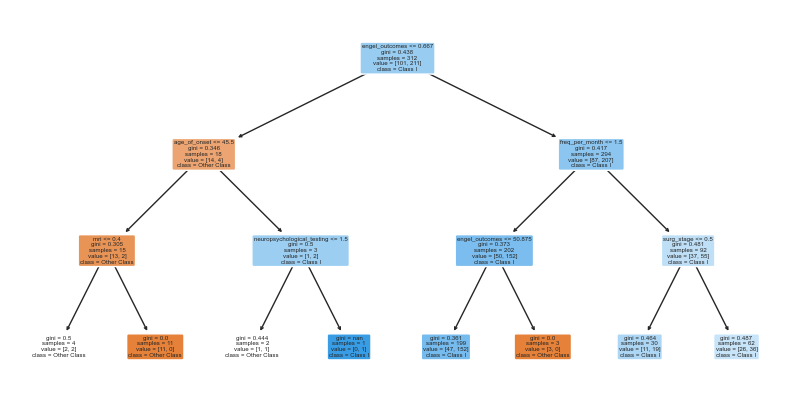

In [32]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(10, 5))
plot_tree(clf, filled=True, feature_names=column_names, class_names=["Other Class", "Class I"], rounded=True)
plt.show()

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


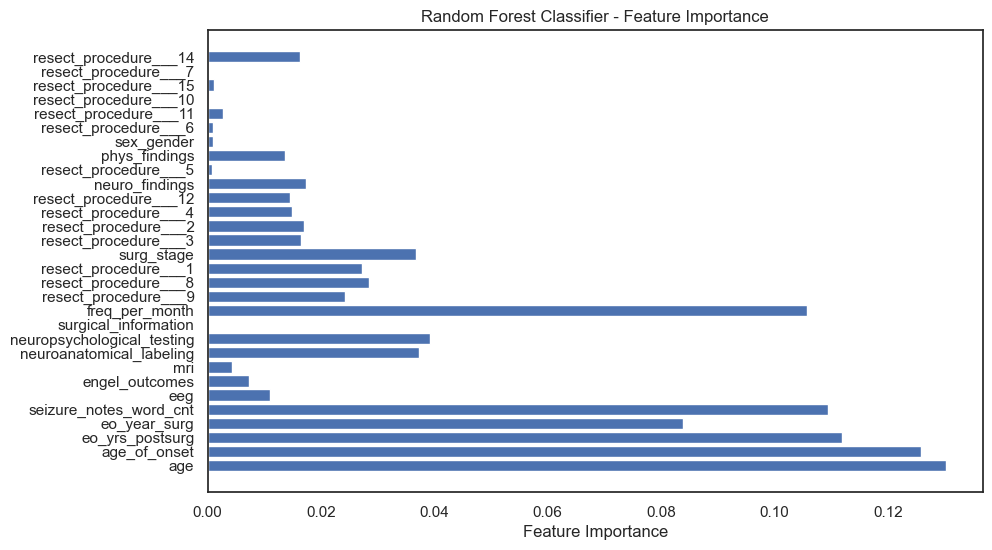

In [34]:
# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

## Support Vector Machines (SVM)

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svc = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


Positive coefficients indicate that the corresponding features are positively correlated with the target class, while negative coefficients indicate a negative correlation.

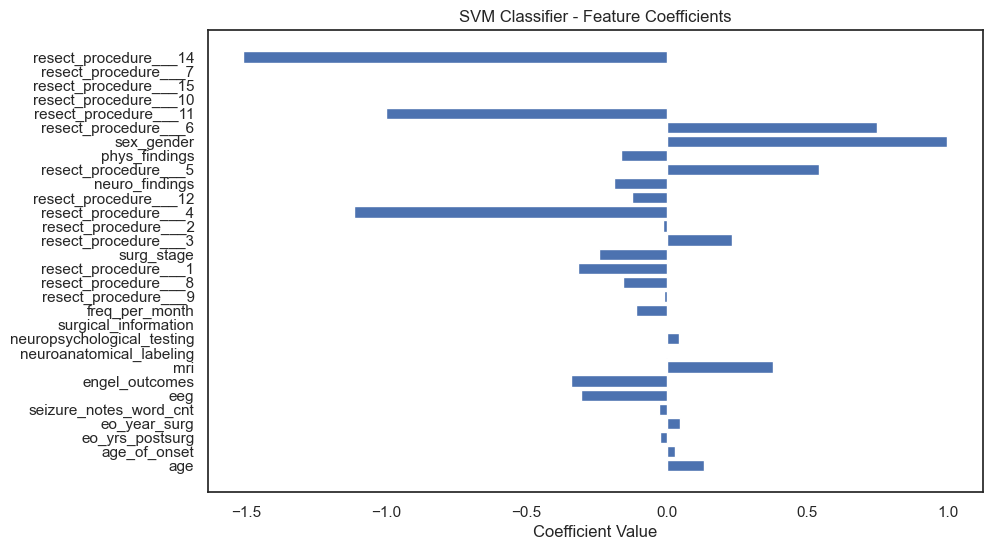

In [36]:
# Get the coefficients (weights) from the trained SVM model
coefficients = svc.coef_.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align="center")
plt.yticks(range(len(coefficients)), column_names)
plt.xlabel("Coefficient Value")
plt.title("SVM Classifier - Feature Coefficients")
plt.show()

In [37]:
(X_train["engel_outcomes"]==2).sum()

3

## XGBoost

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.54


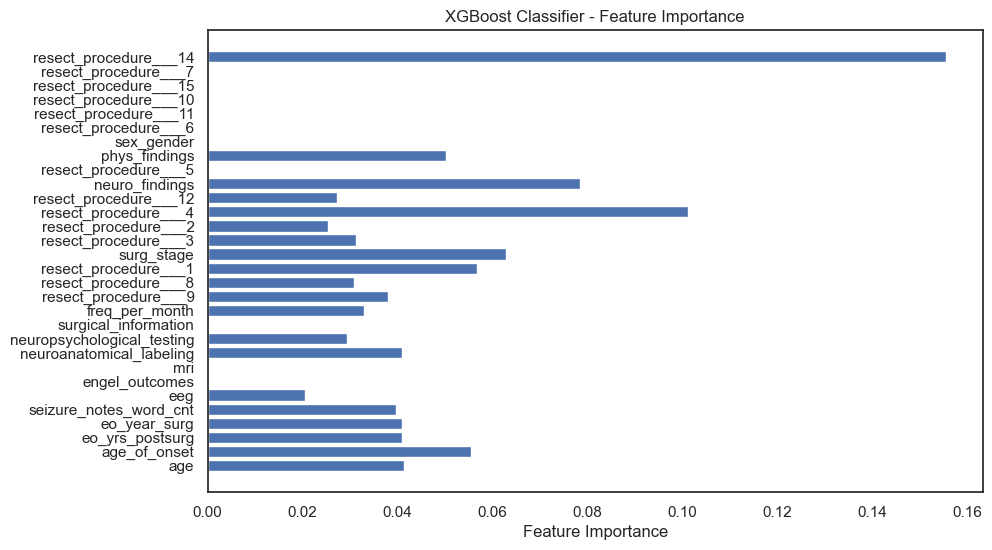

In [39]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [40]:
import tensorflow as tf

# Create a simple neural network model using Keras for binary classification
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")





Epoch 1/5


8/8 - 2s - loss: 0.7175 - accuracy: 0.3414 - val_loss: 0.6985 - val_accuracy: 0.4762 - 2s/epoch - 222ms/step
Epoch 2/5
8/8 - 0s - loss: 0.6820 - accuracy: 0.5944 - val_loss: 0.6662 - val_accuracy: 0.6984 - 69ms/epoch - 9ms/step
Epoch 3/5
8/8 - 0s - loss: 0.6581 - accuracy: 0.6867 - val_loss: 0.6407 - val_accuracy: 0.6984 - 76ms/epoch - 10ms/step
Epoch 4/5
8/8 - 0s - loss: 0.6376 - accuracy: 0.6867 - val_loss: 0.6204 - val_accuracy: 0.6984 - 56ms/epoch - 7ms/step
Epoch 5/5
8/8 - 0s - loss: 0.6261 - accuracy: 0.6827 - val_loss: 0.5986 - val_accuracy: 0.6984 - 52ms/epoch - 7ms/step
3/3 [==============================] - 0s 4ms/step
Accuracy: 0.69


## Perform PCA

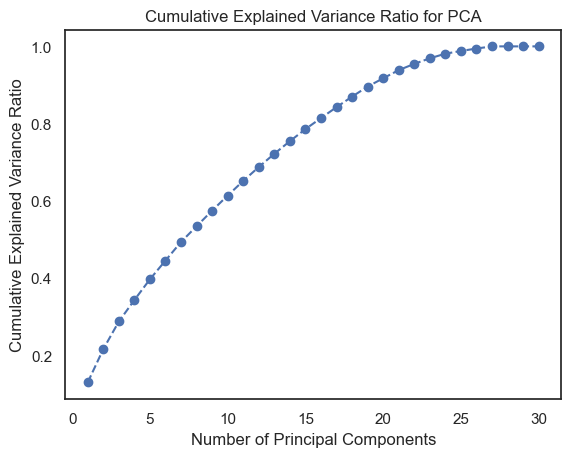

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [42]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Support Vector Machine
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svc.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


## Print system information

In [43]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'